### This random forest model reads data from clean_data_final, and writes to sklearn_models. Here we are using rain as a boolean feature. 

In [29]:
# general 
import datetime
import os

# data analysis and wrangling
import pandas as pd

import numpy as np

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pickling
import pickle

import matplotlib as plt
%matplotlib inline

In [2]:
def train_model(read_directory, write_directory, line):
    
#     Read in the data from a csv file using Pandas
    df = pd.read_csv(read_directory + line + ".csv", low_memory=False)
    
    # Setting up descriptive & target features
    features = ["Day", "Hour", "JourneyPatternID", "Rain", "StopID",]# "JourneyPatternID"] #'LineID', 'JourneyPatternID']

    # converting to categories
    for feature in features:
        df[feature] = df[feature].astype('category')

    # Priming features for the model
    X = pd.concat([df[features]], axis=1)
    y = df.Runtime

    # Creating and training the model 
    rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
    rfc.fit(X, y)
    
    rfc_predictions = rfc.predict(X)
    
    r_value = metrics.r2_score(y, rfc_predictions)
    
    print("R squared for", line, ":", r_value)

    # pickling the model 
#     pickle.dump(rfc, open(write_directory + line + ".sav", 'wb'))



In [3]:
def main(read_directory, write_directory):
    for read_file in os.listdir(read_directory):
        if read_file.endswith(".csv"):
            line = read_file[:-4]
        #             print("Reading", read_file, "from", read_directory)
            if not os.path.isfile(write_directory + line + ".sav"):
                print(write_directory + line + ".sav")
                train_model(read_directory, write_directory, line)            
            print("Finished", read_file)
            print()
    print("Finished main!")

## Main loop to create & pickle models

In [4]:
read_directory = "bus_data/clean_data_final/"
write_directory = "bus_data/sklearn_models2/"

# main(read_directory, write_directory)

## Training Models on different data

In [18]:
read_directory = "bus_data/clean_data_final/"
line = "15"

# Read in the data from a csv file using Pandas
df = pd.read_csv(read_directory + line + ".csv", low_memory=False)


# Setting up descriptive & target features
features = ["Day", "Hour", "JourneyPatternID", "Rain", "StopID"]# "JourneyPatternID"] #'LineID', 'JourneyPatternID']

# converting to categories
for feature in features:
    df[feature] = df[feature].astype('category')

# Priming features for the model
X = pd.concat([df[features]], axis=1)
y = df.Runtime

# Creating and training the model 
rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X, y)

# pickling the model 
#     pickle.dump(rfc, open(write_directory + line + ".sav", 'wb'))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

### Testing the model 

In [19]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(importances)

[ 0.0138607   0.06503464  0.13609264  0.00217396  0.78283807]


R Squared:  0.947821456355
neg_mean_absolute_error:  240.010799253
mean_squared_error:  116692.588958
median_absolute_error:  174.950028468


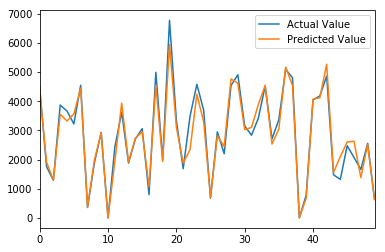

In [35]:
rfc_predictions = rfc.predict(X)

print("R Squared: ", metrics.r2_score(y, rfc_predictions))
print("neg_mean_absolute_error: ", metrics.mean_absolute_error(y, rfc_predictions))
print("mean_squared_error: ", metrics.mean_squared_error(y, rfc_predictions))
print("median_absolute_error: ", metrics.median_absolute_error(y, rfc_predictions))

true_v_pred = pd.DataFrame({'Actual Value': y, 'Predicted Value': rfc_predictions, 'Hour': df.Hour, 'Day': df.Day})

sample = true_v_pred.sample(50).reset_index(drop=True)
# sample.plot()


ax = sample.plot()
fig = ax.get_figure()
fig.savefig('bus_data/images/random_forest.png')

# pd.savefig("bus_data/images/random_forest.png")


In [21]:
rfc_predictions.min()

0.0

In [22]:
correct = 0
window = 300

for index, row in true_v_pred.iterrows():
    tolerance = range(int(row['Predicted Value']) - window, int(row['Predicted Value']) + window)
    if (row['Actual Value'] >= tolerance[0]) and (row['Actual Value'] <= tolerance[-1]):
        correct += 1

accuracy = correct / len(true_v_pred)
print (accuracy)

#0.6049916101840475 - with 4 features (day, hour, stopid, journeypatternid)
#0.6035118316223393 - with 3 features (day, hour, stopid)

0.7141946704239628


## Train Test Split

In [11]:
# Training model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit model on training dataset
rfc.fit(X_train, y_train)

# Predicted class labels for test examples, 
rfc_predictions = rfc.predict(X_test)

R Squared:  0.937833456946
neg_mean_absolute_error:  261.439728971
mean_squared_error:  138317.140917
median_absolute_error:  191.494394002


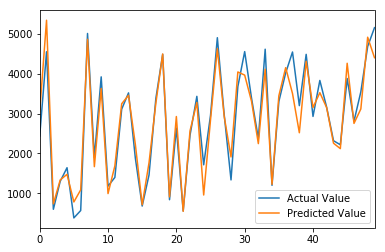

In [12]:
# Accuracy metrics

print("R Squared: ", metrics.r2_score(y_test, rfc_predictions))
print("neg_mean_absolute_error: ", metrics.mean_absolute_error(y_test, rfc_predictions))
print("mean_squared_error: ", metrics.mean_squared_error(y_test, rfc_predictions))
print("median_absolute_error: ", metrics.median_absolute_error(y_test, rfc_predictions))

# y_test,rfc_predictions, hour, day = zip(*sorted(zip(y_test,rfc_predictions, X_test.Hour, X_test.Day),key=lambda x: x[0]))

true_v_pred = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': rfc_predictions}) #, 'Hour': hour, 'Day': day})

sample = true_v_pred.sample(50).reset_index(drop=True)
sample.plot()

In [13]:
rfc_predictions.min()

0.0

### Testing Accuracy (Within margin)

In [17]:
correct = 0
window = 300

for index, row in true_v_pred.iterrows():
    tolerance = range(int(row['Predicted Value']) - window, int(row['Predicted Value']) + window)
    if (row['Actual Value'] >= tolerance[0]) and (row['Actual Value'] <= tolerance[-1]):
        correct += 1

accuracy = correct / len(true_v_pred)
print (accuracy)

#0.6049916101840475 - with 4 features (day, hour, stopid, journeypatternid)
#0.6035118316223393 - with 3 features (day, hour, stopid)

0.6802231834352844
